# pki_models.ipynb

The purpose of this file is to create a logistic regression and support vector machine model based on the normalized PKI dataset found in MLP2.

## Authors
1. Riley Cullen
2. Mason Adsero

## Data

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

pki_df = pd.read_csv("../MLP2/input/heart_2020_normalized.csv")
X = np.c_[pki_df[['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', \
    'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory', \
    'PhysicalActivity', 'GenHealth', 'SleepTime', 'Asthma', 'KidneyDisease', \
    'SkinCancer', 'American Indian/Alaskan Native', 'Asian', 'Black', \
    'Hispanic', 'Other', 'White', 'No diabetes', 'Borderline diabetes', \
    'Has diabetes', 'Has diabetes (during pregnancy)', 'No diabetes']]]
y = np.c_[pki_df['HeartDisease']]

target_names = ['No Heart Disease', 'Has Heart Disease']

print("X shape: ", X.shape)
print("y shape: ", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X shape:  (319795, 26)
y shape:  (319795, 1)
X_train shape:  (223856, 26)
X_test shape:  (95939, 26)
y_train shape:  (223856, 1)
y_test shape:  (95939, 1)


In [84]:
from dataclasses import dataclass

@dataclass
class MetricContainer:
    name: str
    precision: float = 0
    recall: float = 0
    f1_score: float = 0

def average_classification_report(arr: list):
    no_hd = MetricContainer('No Heart Disease')
    has_hd = MetricContainer('Has Heart Disease')

    for elem in arr:
        no_hd.precision += elem['No Heart Disease']['precision']
        no_hd.recall += elem['No Heart Disease']['recall']
        no_hd.f1_score += elem['No Heart Disease']['f1-score']

        has_hd.precision += elem['Has Heart Disease']['precision']
        has_hd.recall += elem['Has Heart Disease']['recall']
        has_hd.f1_score += elem['Has Heart Disease']['f1-score']   

    size = len(arr)
    no_hd.precision /= size
    no_hd.recall /= size
    no_hd.f1_score /= size

    has_hd.precision /= size
    has_hd.recall /= size
    has_hd.f1_score /= size

    print(no_hd)
    print(has_hd)

    return has_hd.recall

def find_optimal_value(values: list, report: list) -> int:
    optimal_value = values[0]
    recall = report[0]

    for idx, val in enumerate(values[0:]):
        if (report[idx] > recall):
            optimal_value = val
            recall = report[idx]
    return optimal_value

## Logistic Regression Model

### Find optimal parameters using 10-fold cross validation
Given the application area (medical classification), we look for the optimal parameters that maximize recall of the "Has Heart Disease" class.

#### Finding the optimal number of max iterations

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

kf = KFold(n_splits=10, random_state=None, shuffle=True)
iter_values = [100, 500, 1000]
iter_report = []

for iter in iter_values:
    logreg = LogisticRegression(max_iter=iter)
    report = []
    for train_id, test_id in kf.split(X_train):
        
        X_train_kf, X_test_kf = X_train[train_id], X_train[test_id]
        y_train_kf, y_test_kf = y_train[train_id], y_train[test_id]

        logreg.fit(X_train_kf, y_train_kf.ravel())

        y_pred = logreg.predict(X_test_kf)

        report.append(classification_report(y_test_kf, y_pred, target_names=target_names, output_dict=True))
    print("Average report at iter = ", iter)
    iter_report.append(average_classification_report(report))

optimal_iter_logreg = find_optimal_value(iter_values, iter_report)
print(optimal_iter_logreg)

/Users/rileycullen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rileycullen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Average report at iter =  100
MetricContainer(name='No Heart Disease', precision=0.9225421348212597, recall=0.9912060031265055, f1_score=0.955641696118301)
MetricContainer(name='Has Heart Disease', precision=0.5417956702363982, recall=0.11108661173182972, f1_score=0.18434183252450573)
Average report at iter =  500
MetricContainer(name='No Heart Disease', precision=0.9224880995224881, recall=0.9912021591235118, f1_score=0.9556091750743307)
MetricContainer(name='Has Heart Disease', precision=0.5401238349597357, recall=0.11046127898949556, f1_score=0.18333849220985354)
Average report at iter =  1000
MetricContainer(name='No Heart Disease', precision=0.922510750083509, recall=0.9912354088959615, f1_score=0.9556387427243044)
MetricContainer(name='Has Heart Disease', precision=0.5421368335183778, recall=0.11066589911996402, f1_score=0.18377453819774825)
0.11108661173182972   0.11108661173182972
0.11046127898949556   0.11108661173182972
0.11066589911996402   0.11108661173182972
100


#### Finding the optimal regularization parameter

In [87]:
c_values = [0.5, 1, 5, 10, 100]
c_report = []

for c in c_values:
    logreg = LogisticRegression(C=c)
    report = []
    for train_id, test_id in kf.split(X_train):
        
        X_train_kf, X_test_kf = X_train[train_id], X_train[test_id]
        y_train_kf, y_test_kf = y_train[train_id], y_train[test_id]

        logreg.fit(X_train_kf, y_train_kf.ravel())

        y_pred = logreg.predict(X_test_kf)

        report.append(classification_report(y_test_kf, y_pred, target_names=target_names, output_dict=True))
    print("Average report at iter = ", c)
    c_report.append(average_classification_report(report))

optimal_c_logreg = find_optimal_value(c_values, c_report)
print(optimal_c_logreg)

/Users/rileycullen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rileycullen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Average report at iter =  0.5
MetricContainer(name='No Heart Disease', precision=0.9224909992488561, recall=0.9912593926786457, f1_score=0.9556387319844545)
MetricContainer(name='Has Heart Disease', precision=0.5419304464489939, recall=0.1104023632476169, f1_score=0.18339766218453152)


/Users/rileycullen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rileycullen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Average report at iter =  1
MetricContainer(name='No Heart Disease', precision=0.9225433100531557, recall=0.9912256627218863, f1_score=0.9556500945734209)
MetricContainer(name='Has Heart Disease', precision=0.5423893118339324, recall=0.1111337685757821, f1_score=0.18445260597325763)
Average report at iter =  5
MetricContainer(name='No Heart Disease', precision=0.9225453637273651, recall=0.9911776580120198, f1_score=0.9556299606354273)
MetricContainer(name='Has Heart Disease', precision=0.5416060423153846, recall=0.11115424154839895, f1_score=0.18435013450491516)
Average report at iter =  10
MetricContainer(name='No Heart Disease', precision=0.9225187260621901, recall=0.9912212194335099, f1_score=0.9556360075722145)
MetricContainer(name='Has Heart Disease', precision=0.5421266837886116, recall=0.11079134568885947, f1_score=0.18390376606068123)
Average report at iter =  100
MetricContainer(name='No Heart Disease', precision=0.9225238908276141, recall=0.9911676950303688, f1_score=0.955613

### Train model using optimal parameters

In [88]:
logreg = LogisticRegression(max_iter=optimal_iter_logreg, C=optimal_c_logreg)
logreg.fit(X_train, y_train)

/Users/rileycullen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression(C=5)

### Evaluation on test data

In [89]:
y_pred = logreg.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred, labels=[1, 0])
print(confusion_mat, "\n\n")

print(classification_report(y_test, y_pred, target_names=target_names))

[[  858  7351]
 [  750 86980]] 


                   precision    recall  f1-score   support

 No Heart Disease       0.92      0.99      0.96     87730
Has Heart Disease       0.53      0.10      0.17      8209

         accuracy                           0.92     95939
        macro avg       0.73      0.55      0.57     95939
     weighted avg       0.89      0.92      0.89     95939



Accuracy =  0.8399304241880907


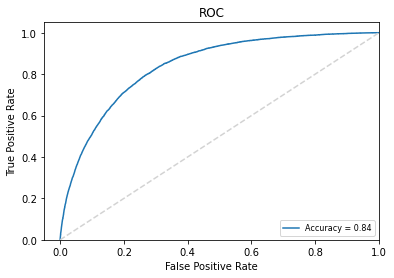

In [90]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_score = logreg.predict_proba(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_score[:,1])

roc_auc = auc(false_positive_rate, true_positive_rate)

print('Accuracy = ', roc_auc)

# Plotting
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, label=('Accuracy = %0.2f'%roc_auc))
plt.legend(loc='lower right', prop={'size':8})
plt.plot([0,1],[0,1], color='lightgrey', linestyle='--')
plt.xlim([-0.05,1.0])
plt.ylim([0.0,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Support Vector Machine

### Train and Validate Model

In [58]:
from sklearn.svm import LinearSVC

svm = LinearSVC()

for train_id, test_id in kf.split(X_train):
    
    X_train_kf, X_test_kf = X_train[train_id], X_train[test_id]
    y_train_kf, y_test_kf = y_train[train_id], y_train[test_id]

    svm.fit(X_train_kf, y_train_kf.ravel())

    y_pred = svm.predict(X_test_kf)
    
    confusion_mat = confusion_matrix(y_test_kf, y_pred)

    print(classification_report(y_test_kf, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

 No Heart Disease       0.91      1.00      0.95     20424
Has Heart Disease       0.57      0.03      0.07      1962

         accuracy                           0.91     22386
        macro avg       0.74      0.52      0.51     22386
     weighted avg       0.88      0.91      0.88     22386

                   precision    recall  f1-score   support

 No Heart Disease       0.92      1.00      0.96     20511
Has Heart Disease       0.65      0.04      0.08      1875

         accuracy                           0.92     22386
        macro avg       0.78      0.52      0.52     22386
     weighted avg       0.90      0.92      0.88     22386

                   precision    recall  f1-score   support

 No Heart Disease       0.92      1.00      0.96     20469
Has Heart Disease       0.75      0.04      0.08      1917

         accuracy                           0.92     22386
        macro avg       0.83      0.52      0.52

### Test model

In [59]:
y_pred = svm.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred, labels=[1, 0])
print(confusion_mat, "\n\n")

print(classification_report(y_test, y_pred, target_names=target_names))

[[  306  7903]
 [  199 87531]] 


                   precision    recall  f1-score   support

 No Heart Disease       0.92      1.00      0.96     87730
Has Heart Disease       0.61      0.04      0.07      8209

         accuracy                           0.92     95939
        macro avg       0.76      0.52      0.51     95939
     weighted avg       0.89      0.92      0.88     95939



Accuracy =  0.8391407417499597


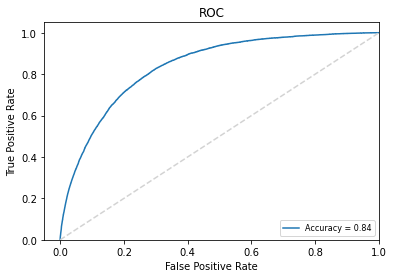

In [60]:
y_score = svm.decision_function(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_score)

roc_auc = auc(false_positive_rate, true_positive_rate)

print('Accuracy = ', roc_auc)

# Plotting
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, label=('Accuracy = %0.2f'%roc_auc))
plt.legend(loc='lower right', prop={'size':8})
plt.plot([0,1],[0,1], color='lightgrey', linestyle='--')
plt.xlim([-0.05,1.0])
plt.ylim([0.0,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()